In [144]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## assumed contamination level
alpha= 0.1
start_epoch= 0

## example data , same shape as the output of the model
torch.manual_seed(42)
recon = torch.randn(2, 448, 64, 64) 
outputs = torch.randn(2, 448, 64, 64)  

weight_exp=[]
weight_lin=[]
loss_exp=[]
loss_lin=[]
epochs=np.arange(20)


for epoch in epochs:
    # Compute loss per image and channel, and then flatten

    individual_losses = F.mse_loss(recon, outputs, reduction='none').mean([2, 3])  # Shape is (batch_size, channels)
    flattened_losses = individual_losses.view(-1)

    quantile = torch.quantile(flattened_losses, alpha)
    lower = flattened_losses[flattened_losses <= quantile]
    upper = flattened_losses[flattened_losses > quantile]


    # exponential weight decay
    b=0.5
    lossweight=np.round(alpha * np.exp(-epoch*b),12)  
    total_loss_exp=(1-lossweight) * lower.mean() +  lossweight * upper.mean()
    weight_exp.append(lossweight), loss_exp.append(total_loss_exp)


    # linear weight decay #TODO linear
    a=0.09
    lossweight = np.maximum(0, np.round((1 - alpha) -  epoch * a, 12))
    total_loss_lin=(1-lossweight) * lower.mean() +  lossweight * upper.mean()
    weight_lin.append(lossweight), loss_lin.append(total_loss_lin)
    

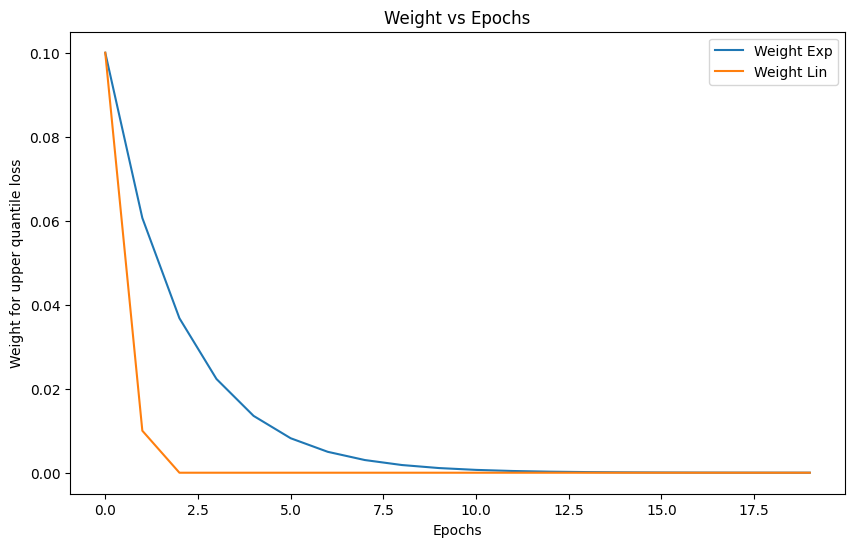

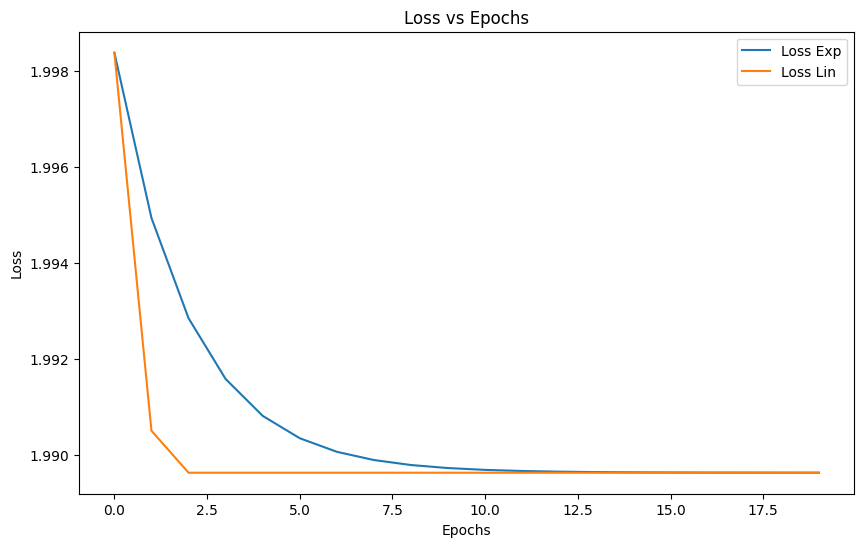

In [145]:

# Plot 1: Weight vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, weight_exp, label='Weight Exp')
plt.plot(epochs, weight_lin, label='Weight Lin')
plt.xlabel('Epochs')
plt.ylabel('Weight for upper quantile loss')
plt.title('Weight vs Epochs')
plt.legend()
plt.show()

# Plot 2: Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_exp, label='Loss Exp')
plt.plot(epochs, loss_lin, label='Loss Lin')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


In [ ]:
loss_scale = criterion(std, torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).detach())

In [146]:
## fucniton for main

def weighted_loss(recon, outputs, alpha, epoch):
    individual_losses = F.mse_loss(recon, outputs, reduction='none').mean([2, 3])  # Shape is (batch_size, channels)
    flattened_losses = individual_losses.view(-1)

    quantile = torch.quantile(flattened_losses, alpha)
    lower = flattened_losses[flattened_losses <= quantile]
    upper = flattened_losses[flattened_losses > quantile]

    # exponential weight decay other functions possible here
    b=0.5
    lossweight=np.round((1-alpha) * np.exp(-epoch*b),12)  
    
    ## linaer weight decay
    # a=0.09
    # lossweight = np.maximum(0, np.round((1 - alpha) -  epoch * a, 12))
    
    # weighted loss
    total_loss_exp=(1-lossweight) * lower.mean() +  lossweight * upper.mean()
    return total_loss_exp